# Numerical Analysis Encryption Experiment (Robust Version)

This notebook supports two input modes:
- `synthetic`: auto-generate controlled test images
- `custom`: use your own images from `data/custom_images`

Pipeline:
1. Build or load images
2. Encrypt blocks with dense/sparse keys
3. Inject Gaussian noise
4. Decrypt with Gaussian Elimination, LU, and Gauss-Seidel
5. Export reproducible metrics, plots, and LaTeX tables


In [20]:
# HOW TO RUN
# 1) pip install numpy matplotlib
# 2) Put your images in data/custom_images (png/jpg/jpeg/bmp/tif/tiff)
# 3) In CONFIG, set data_source to "custom" (or "synthetic" for auto data)
# 4) Run all cells from top to bottom
# 5) Check outputs in out/: CSV, figures, convergence traces, and LaTeX tables

import csv
import json
import math
import time
import subprocess
from datetime import datetime, timezone
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(suppress=True, precision=4)


In [21]:
# =========================
# Global configuration
# =========================
CONFIG = {
    "seed": 42,
    "data_source": "custom",  # "synthetic" or "custom"
    "custom_image_dir": "data/custom_images",
    "max_custom_images": 20,
    "save_loaded_images": True,

    "image_size": 128,
    "block_size": 8,
    "num_synthetic_images": 12,

    "noise_sigmas": [0.0, 0.01, 0.03, 0.07, 0.12],
    "repeats": 3,

    "gs_tol": 1e-6,
    "gs_max_iters": 200,

    "sparse_density": 0.08,
    "dense_diag_boost": 24.0,
    "sparse_diag_boost": 10.0,

    "warmup_solver_once_per_call": True,
    "convergence_trace_images_per_sigma": 1,
    "sigma_for_latex_table": 0.01,
    "save_wall_error_maps": True,
    "save_solver_ranking": True,
}

ROOT = Path.cwd()
DATA_DIR = ROOT / "data"
SYNTH_DIR = DATA_DIR / "synthetic"
CUSTOM_DIR = ROOT / CONFIG["custom_image_dir"]
PROCESSED_DIR = DATA_DIR / "processed"
OUT_DIR = ROOT / "out"
FIG_DIR = OUT_DIR / "figures"
TABLE_DIR = OUT_DIR / "tables"
TRACE_DIR = OUT_DIR / "traces"

for p in [SYNTH_DIR, PROCESSED_DIR, OUT_DIR, FIG_DIR, TABLE_DIR, TRACE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

if CONFIG["image_size"] % CONFIG["block_size"] != 0:
    raise ValueError("image_size must be divisible by block_size")

rng = np.random.default_rng(CONFIG["seed"])
VECTOR_SIZE = CONFIG["block_size"] * CONFIG["block_size"]

(OUT_DIR / "config.json").write_text(json.dumps(CONFIG, indent=2), encoding="utf-8")
print("Saved config:", OUT_DIR / "config.json")


Saved config: e:\Projects\Numerical-Analysis-Project\out\config.json


In [22]:
def minmax01(x):
    x = x.astype(np.float64)
    mn, mx = x.min(), x.max()
    if mx - mn < 1e-12:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)


def rgb_to_gray(img):
    # Expects either HxW or HxWxC
    if img.ndim == 2:
        return img.astype(np.float64)
    if img.ndim == 3:
        if img.shape[2] == 4:
            img = img[:, :, :3]
        r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        return (0.299 * r + 0.587 * g + 0.114 * b).astype(np.float64)
    raise ValueError("Unsupported image shape")


def resize_nearest(img, out_h, out_w):
    in_h, in_w = img.shape
    row_idx = np.linspace(0, in_h - 1, out_h).astype(int)
    col_idx = np.linspace(0, in_w - 1, out_w).astype(int)
    return img[row_idx][:, col_idx]


def validate_image(img, name="unknown"):
    if img.ndim != 2:
        raise ValueError(f"{name}: expected 2D grayscale image")
    if not np.isfinite(img).all():
        raise ValueError(f"{name}: contains non-finite values")
    if img.shape[0] < 16 or img.shape[1] < 16:
        raise ValueError(f"{name}: image is too small")


Data source: custom
Number of images: 20
Image size: (128, 128)


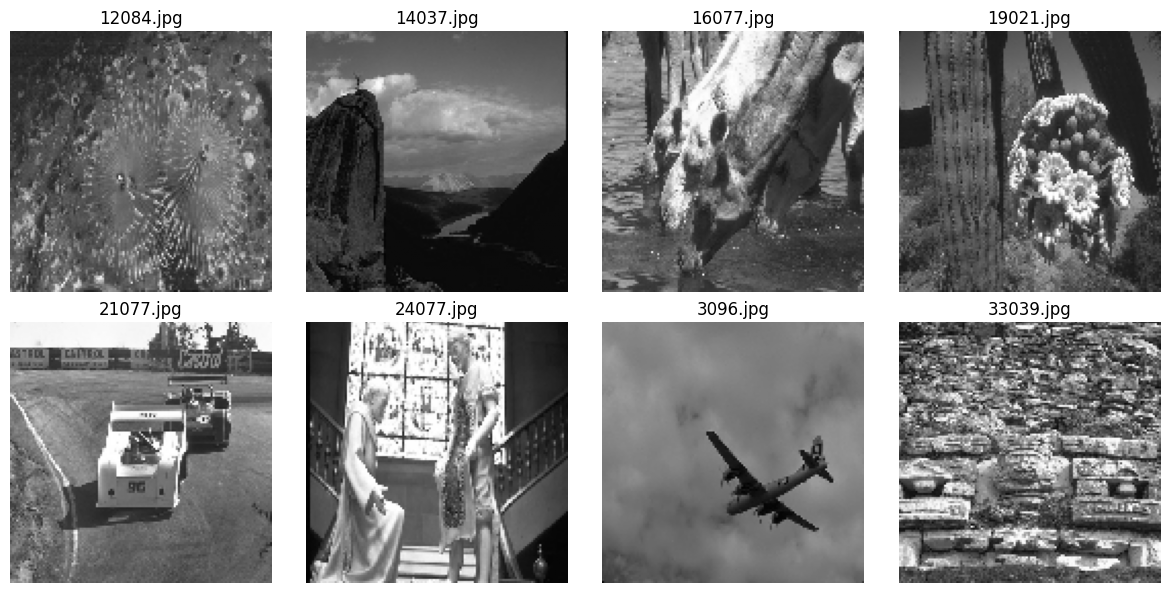

In [23]:
def generate_pattern_image(kind, size, rng):
    y, x = np.mgrid[0:size, 0:size]
    x = x / (size - 1)
    y = y / (size - 1)

    if kind % 6 == 0:
        img = 0.6 * x + 0.4 * y
    elif kind % 6 == 1:
        img = ((np.floor(x * 12) + np.floor(y * 12)) % 2).astype(float)
    elif kind % 6 == 2:
        cx, cy = 0.5 + 0.1 * rng.standard_normal(), 0.5 + 0.1 * rng.standard_normal()
        r = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
        img = np.cos(25 * r)
    elif kind % 6 == 3:
        img = np.sin(18 * x) * np.cos(14 * y)
    elif kind % 6 == 4:
        img = np.exp(-((x - 0.35) ** 2 + (y - 0.35) ** 2) / 0.02) + 0.8 * np.exp(-((x - 0.7) ** 2 + (y - 0.65) ** 2) / 0.04)
    else:
        img = np.sin(8 * np.pi * x) + np.sin(8 * np.pi * y) + 0.25 * rng.standard_normal((size, size))

    img = minmax01(img)
    img += 0.02 * rng.standard_normal((size, size))
    return np.clip(img, 0.0, 1.0)


def build_synthetic_dataset(num_images, size, rng):
    images = []
    image_names = []
    for i in range(num_images):
        img = generate_pattern_image(i, size, rng)
        name = f"img_{i:02d}"
        images.append(img)
        image_names.append(name)
        np.save(SYNTH_DIR / f"{name}.npy", img)
        plt.imsave(SYNTH_DIR / f"{name}.png", img, cmap="gray", vmin=0.0, vmax=1.0)
    return images, image_names


def load_custom_images(folder, out_size, max_images=None):
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
    if not folder.exists():
        return [], []

    files = sorted([p for p in folder.iterdir() if p.suffix.lower() in exts])
    if max_images is not None:
        files = files[:max_images]

    images = []
    image_names = []
    for p in files:
        raw = plt.imread(p)
        gray = rgb_to_gray(raw)
        gray = gray.astype(np.float64)

        if gray.max() > 1.0:
            gray = gray / 255.0
        gray = np.clip(gray, 0.0, 1.0)

        resized = resize_nearest(gray, out_size, out_size)
        validate_image(resized, name=p.name)
        images.append(resized)
        image_names.append(p.name)

        if CONFIG["save_loaded_images"]:
            stem = p.stem.replace(" ", "_")
            np.save(PROCESSED_DIR / f"{stem}.npy", resized)
            plt.imsave(PROCESSED_DIR / f"{stem}.png", resized, cmap="gray", vmin=0.0, vmax=1.0)

    return images, image_names


if CONFIG["data_source"] == "custom":
    images, image_names = load_custom_images(CUSTOM_DIR, CONFIG["image_size"], CONFIG["max_custom_images"])
    if len(images) == 0:
        print("No custom images found. Falling back to synthetic dataset.")
        images, image_names = build_synthetic_dataset(CONFIG["num_synthetic_images"], CONFIG["image_size"], rng)
        source_name = "synthetic_fallback"
    else:
        source_name = "custom"
else:
    images, image_names = build_synthetic_dataset(CONFIG["num_synthetic_images"], CONFIG["image_size"], rng)
    source_name = "synthetic"

if len(images) == 0:
    raise RuntimeError("No images available for experiment")

print("Data source:", source_name)
print("Number of images:", len(images))
print("Image size:", images[0].shape)

preview = min(8, len(images))
rows = 2
cols = int(np.ceil(preview / rows))
fig, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
ax = np.array(ax).reshape(-1)
for i in range(preview):
    ax[i].imshow(images[i], cmap="gray", vmin=0.0, vmax=1.0)
    ax[i].set_title(image_names[i][:18])
    ax[i].axis("off")
for i in range(preview, len(ax)):
    ax[i].axis("off")
fig.tight_layout()
plt.show()


In [24]:
def split_blocks(img, b=8):
    h, w = img.shape
    assert h % b == 0 and w % b == 0
    blocks = []
    for r in range(0, h, b):
        for c in range(0, w, b):
            blocks.append(img[r:r+b, c:c+b].reshape(-1))
    return np.asarray(blocks)


def merge_blocks(blocks, h, w, b=8):
    out = np.zeros((h, w), dtype=np.float64)
    idx = 0
    for r in range(0, h, b):
        for c in range(0, w, b):
            out[r:r+b, c:c+b] = blocks[idx].reshape(b, b)
            idx += 1
    return np.clip(out, 0.0, 1.0)


def mse(a, b):
    return float(np.mean((a - b) ** 2))


def psnr(a, b, peak=1.0):
    e = mse(a, b)
    if e <= 1e-15:
        return 99.0
    return 10.0 * math.log10((peak ** 2) / e)


def relative_error(x_hat, x):
    denom = np.linalg.norm(x)
    if denom < 1e-15:
        return float(np.linalg.norm(x_hat - x))
    return float(np.linalg.norm(x_hat - x) / denom)


In [25]:
def make_dense_key(n, rng, diag_boost):
    A = rng.normal(0.0, 1.0, (n, n))
    A += float(diag_boost) * np.eye(n)
    return A


def make_sparse_key(n, density, rng, diag_boost):
    mask = rng.random((n, n)) < density
    A = rng.normal(0.0, 1.0, (n, n)) * mask
    A += float(diag_boost) * np.eye(n)
    return A


def gaussian_elimination_solve(A, b):
    A = A.astype(np.float64).copy()
    b = b.astype(np.float64).copy()
    n = A.shape[0]

    for k in range(n - 1):
        pivot = k + np.argmax(np.abs(A[k:, k]))
        if abs(A[pivot, k]) < 1e-15:
            raise np.linalg.LinAlgError("Singular matrix in Gaussian elimination")
        if pivot != k:
            A[[k, pivot]] = A[[pivot, k]]
            b[[k, pivot]] = b[[pivot, k]]

        for i in range(k + 1, n):
            factor = A[i, k] / A[k, k]
            A[i, k:] -= factor * A[k, k:]
            b[i] -= factor * b[k]

    x = np.zeros(n, dtype=np.float64)
    for i in range(n - 1, -1, -1):
        s = np.dot(A[i, i + 1:], x[i + 1:])
        x[i] = (b[i] - s) / A[i, i]
    return x


def lu_factorize(A):
    A = A.astype(np.float64).copy()
    n = A.shape[0]
    P = np.arange(n)

    for k in range(n - 1):
        pivot = k + np.argmax(np.abs(A[k:, k]))
        if abs(A[pivot, k]) < 1e-15:
            raise np.linalg.LinAlgError("Singular matrix in LU factorization")
        if pivot != k:
            A[[k, pivot], :] = A[[pivot, k], :]
            P[[k, pivot]] = P[[pivot, k]]

        for i in range(k + 1, n):
            A[i, k] /= A[k, k]
            A[i, k + 1:] -= A[i, k] * A[k, k + 1:]

    return A, P


def lu_solve(LU, P, b):
    n = LU.shape[0]
    bp = b[P]

    y = np.zeros(n, dtype=np.float64)
    for i in range(n):
        y[i] = bp[i] - np.dot(LU[i, :i], y[:i])

    x = np.zeros(n, dtype=np.float64)
    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - np.dot(LU[i, i + 1:], x[i + 1:])) / LU[i, i]

    return x


def gauss_seidel(A, b, tol=1e-6, max_iters=200, x0=None, track_history=False):
    n = A.shape[0]
    x = np.zeros(n, dtype=np.float64) if x0 is None else x0.astype(np.float64).copy()

    D = np.diag(A)
    if np.any(np.abs(D) < 1e-15):
        raise np.linalg.LinAlgError("Zero diagonal entry in Gauss-Seidel")

    history = []
    for k in range(max_iters):
        x_old = x.copy()
        for i in range(n):
            sigma1 = np.dot(A[i, :i], x[:i])
            sigma2 = np.dot(A[i, i + 1:], x_old[i + 1:])
            x[i] = (b[i] - sigma1 - sigma2) / A[i, i]

        r = b - A @ x
        rel_res = np.linalg.norm(r) / (np.linalg.norm(b) + 1e-15)
        if track_history:
            history.append(float(rel_res))
        if rel_res < tol:
            return x, k + 1, rel_res, False, history

    r = b - A @ x
    rel_res = np.linalg.norm(r) / (np.linalg.norm(b) + 1e-15)
    if track_history and (len(history) == 0 or history[-1] != float(rel_res)):
        history.append(float(rel_res))
    return x, max_iters, rel_res, True, history


In [26]:
def _warmup_solver_once(A, b, solver_name):
    if not CONFIG["warmup_solver_once_per_call"]:
        return
    try:
        if solver_name == "lu":
            LU, P = lu_factorize(A)
            _ = lu_solve(LU, P, b)
        elif solver_name == "gaussian":
            _ = gaussian_elimination_solve(A, b)
        elif solver_name == "gauss_seidel":
            _ = gauss_seidel(A, b, tol=CONFIG["gs_tol"], max_iters=CONFIG["gs_max_iters"]) 
        elif solver_name == "np_solve":
            _ = np.linalg.solve(A, b)
    except Exception:
        pass


def decrypt_blocks(A, blocks_noisy, solver_name, gs_tol, gs_max_iters):
    dec = np.zeros_like(blocks_noisy)
    gs_iters = []
    gs_hits_max = 0
    failed_blocks = 0
    error_messages = []

    if len(blocks_noisy) > 0:
        _warmup_solver_once(A, blocks_noisy[0], solver_name)

    t0_ns = time.perf_counter_ns()

    try:
        if solver_name == "lu":
            LU, P = lu_factorize(A)
            for i, b in enumerate(blocks_noisy):
                try:
                    dec[i] = lu_solve(LU, P, b)
                except Exception as e:
                    failed_blocks += 1
                    error_messages.append(str(e))

        elif solver_name == "gaussian":
            for i, b in enumerate(blocks_noisy):
                try:
                    dec[i] = gaussian_elimination_solve(A, b)
                except Exception as e:
                    failed_blocks += 1
                    error_messages.append(str(e))

        elif solver_name == "gauss_seidel":
            for i, b in enumerate(blocks_noisy):
                try:
                    xhat, iters, _, hit_max, _ = gauss_seidel(A, b, tol=gs_tol, max_iters=gs_max_iters, track_history=False)
                    dec[i] = xhat
                    gs_iters.append(iters)
                    gs_hits_max += int(hit_max)
                except Exception as e:
                    failed_blocks += 1
                    error_messages.append(str(e))

        elif solver_name == "np_solve":
            for i, b in enumerate(blocks_noisy):
                try:
                    dec[i] = np.linalg.solve(A, b)
                except Exception as e:
                    failed_blocks += 1
                    error_messages.append(str(e))
        else:
            raise ValueError(f"Unknown solver: {solver_name}")

    except Exception as e:
        failed_blocks = len(blocks_noisy)
        error_messages.append(str(e))

    elapsed_ms = (time.perf_counter_ns() - t0_ns) / 1_000_000.0
    status = "ok" if failed_blocks == 0 else "partial_fail"
    err_msg = " | ".join(error_messages[:2]) if error_messages else ""

    return {
        "dec_blocks": dec,
        "time_ms": float(elapsed_ms),
        "gs_iters": gs_iters,
        "gs_hits_max": gs_hits_max,
        "failed_blocks": int(failed_blocks),
        "status": status,
        "error_message": err_msg,
    }


def run_experiment(images, image_names, matrix_type, A):
    records = []
    trace_rows = []
    condA = float(np.linalg.cond(A))

    for sigma in CONFIG["noise_sigmas"]:
        for rep in range(CONFIG["repeats"]):
            for img_idx, img in enumerate(images):
                img_name = image_names[img_idx] if img_idx < len(image_names) else f"img_{img_idx:02d}"
                blocks = split_blocks(img, CONFIG["block_size"])
                encrypted = blocks @ A.T
                noisy = encrypted + sigma * rng.standard_normal(encrypted.shape)

                for solver in ["np_solve", "gaussian", "lu", "gauss_seidel"]:
                    out = decrypt_blocks(
                        A,
                        noisy,
                        solver,
                        gs_tol=CONFIG["gs_tol"],
                        gs_max_iters=CONFIG["gs_max_iters"],
                    )
                    dec_blocks = out["dec_blocks"]

                    metrics_ok = out["failed_blocks"] < len(blocks)
                    if metrics_ok:
                        rec_img = merge_blocks(dec_blocks, img.shape[0], img.shape[1], CONFIG["block_size"])
                        x_true = blocks.ravel()
                        x_hat = dec_blocks.ravel()
                        b_vec = noisy.ravel()

                        residual = float(
                            np.linalg.norm((dec_blocks @ A.T).ravel() - b_vec)
                            / (np.linalg.norm(b_vec) + 1e-15)
                        )

                        psnr_v = psnr(rec_img, img)
                        mse_v = mse(rec_img, img)
                        rel_err_v = relative_error(x_hat, x_true)
                    else:
                        psnr_v = float("nan")
                        mse_v = float("nan")
                        rel_err_v = float("nan")
                        residual = float("nan")

                    n_blocks = len(blocks)
                    gs_avg_iters = float(np.mean(out["gs_iters"])) if out["gs_iters"] else 0.0
                    gs_hit_max_ratio = float(out["gs_hits_max"] / n_blocks) if n_blocks > 0 else 0.0

                    records.append({
                        "matrix_type": matrix_type,
                        "solver": solver,
                        "sigma": float(sigma),
                        "repeat": int(rep),
                        "image_idx": int(img_idx),
                        "image_name": img_name,
                        "data_source": source_name,
                        "seed": int(CONFIG["seed"]),
                        "status": out["status"],
                        "error_message": out["error_message"],
                        "failed_blocks": int(out["failed_blocks"]),
                        "psnr_db": float(psnr_v),
                        "mse": float(mse_v),
                        "relative_error": float(rel_err_v),
                        "relative_residual": float(residual),
                        "condition_number": condA,
                        "time_ms": float(out["time_ms"]),
                        "gs_avg_iters": gs_avg_iters,
                        "gs_hit_max_ratio": gs_hit_max_ratio,
                    })

                # Save a small set of Gauss-Seidel convergence traces for analysis
                if rep == 0 and img_idx < CONFIG["convergence_trace_images_per_sigma"]:
                    b0 = noisy[0]
                    try:
                        _, _, _, _, hist = gauss_seidel(
                            A,
                            b0,
                            tol=CONFIG["gs_tol"],
                            max_iters=CONFIG["gs_max_iters"],
                            track_history=True,
                        )
                        for it, rel_res in enumerate(hist, start=1):
                            trace_rows.append({
                                "matrix_type": matrix_type,
                                "sigma": float(sigma),
                                "image_idx": int(img_idx),
                                "image_name": img_name,
                                "iteration": int(it),
                                "relative_residual": float(rel_res),
                            })
                    except Exception:
                        pass

    return records, trace_rows


In [ ]:
A_dense = make_dense_key(VECTOR_SIZE, rng, CONFIG["dense_diag_boost"])
A_sparse = make_sparse_key(VECTOR_SIZE, CONFIG["sparse_density"], rng, CONFIG["sparse_diag_boost"])

print("cond(A_dense) =", np.linalg.cond(A_dense))
print("cond(A_sparse)=", np.linalg.cond(A_sparse))

# Run manifest with environment/context metadata
try:
    git_hash = subprocess.check_output(["git", "rev-parse", "--short", "HEAD"], cwd=str(ROOT), text=True).strip()
except Exception:
    git_hash = "unknown"

run_info = {
    "timestamp_utc": datetime.now(timezone.utc).isoformat(),
    "project_root": str(ROOT),
    "git_hash": git_hash,
    "data_source": source_name,
    "image_count": len(images),
    "image_size": list(images[0].shape),
    "config": CONFIG,
}
(OUT_DIR / "run_info.json").write_text(json.dumps(run_info, indent=2), encoding="utf-8")
print("Saved run manifest:", OUT_DIR / "run_info.json")

records = []
trace_rows = []

dense_records, dense_traces = run_experiment(images, image_names, "dense", A_dense)
sparse_records, sparse_traces = run_experiment(images, image_names, "sparse", A_sparse)

records.extend(dense_records)
records.extend(sparse_records)
trace_rows.extend(dense_traces)
trace_rows.extend(sparse_traces)

print("Total records:", len(records))
print("Total convergence trace rows:", len(trace_rows))


cond(A_dense) = 2.4571948447624705
cond(A_sparse)= 1.9421462614413834
Saved run manifest: e:\Projects\Numerical-Analysis-Project\out\run_info.json


In [ ]:
def aggregate_records(records):
    agg = defaultdict(list)
    for r in records:
        agg[(r["matrix_type"], r["solver"], r["sigma"])].append(r)

    summary = []
    for (mt, sv, sg), rows in sorted(agg.items()):
        def finite_vals(key):
            vals = np.array([rr[key] for rr in rows], dtype=float)
            return vals[np.isfinite(vals)]

        def mean_std(key):
            vals = finite_vals(key)
            if len(vals) == 0:
                return float("nan"), float("nan")
            std = float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0
            return float(np.mean(vals)), std

        def median_iqr(key):
            vals = finite_vals(key)
            if len(vals) == 0:
                return float("nan"), float("nan")
            q1, q3 = np.percentile(vals, [25, 75])
            return float(np.median(vals)), float(q3 - q1)

        psnr_m, psnr_s = mean_std("psnr_db")
        mse_m, mse_s = mean_std("mse")
        err_m, err_s = mean_std("relative_error")
        res_m, res_s = mean_std("relative_residual")
        time_m, time_s = mean_std("time_ms")
        time_med, time_iqr = median_iqr("time_ms")
        it_m, it_s = mean_std("gs_avg_iters")
        hit_m, hit_s = mean_std("gs_hit_max_ratio")

        ok_count = sum(1 for rr in rows if rr["status"] == "ok")
        success_rate = ok_count / len(rows) if len(rows) > 0 else 0.0

        summary.append({
            "matrix_type": mt,
            "solver": sv,
            "sigma": float(sg),
            "cond": float(rows[0]["condition_number"]),
            "sample_count": int(len(rows)),
            "success_rate": float(success_rate),
            "psnr_mean": psnr_m,
            "psnr_std": psnr_s,
            "mse_mean": mse_m,
            "mse_std": mse_s,
            "rel_err_mean": err_m,
            "rel_err_std": err_s,
            "residual_mean": res_m,
            "residual_std": res_s,
            "time_ms_mean": time_m,
            "time_ms_std": time_s,
            "time_ms_median": time_med,
            "time_ms_iqr": time_iqr,
            "gs_iters_mean": it_m,
            "gs_iters_std": it_s,
            "gs_hit_max_ratio_mean": hit_m,
            "gs_hit_max_ratio_std": hit_s,
        })
    return summary


def write_csv(path, rows):
    if len(rows) == 0:
        return
    with open(path, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
        w.writeheader()
        for row in rows:
            w.writerow(row)


def write_latex_table(path, rows, matrix_type, sigma):
    chosen = [r for r in rows if r["matrix_type"] == matrix_type and abs(r["sigma"] - sigma) < 1e-12]
    chosen = sorted(chosen, key=lambda x: x["solver"])

    with open(path, "w", encoding="utf-8") as f:
        f.write("% Auto-generated from code.ipynb\n")
        f.write("\\begin{tabular}{lrrrrrrr}\n")
        f.write("\\toprule\n")
        f.write("Solver & PSNR & MSE & RelErr & Residual & TimeMed(ms) & TimeIQR & Success\\\\\n")
        f.write("\\midrule\n")
        for r in chosen:
            f.write(
                f"{r['solver']} & {r['psnr_mean']:.3f} & {r['mse_mean']:.6f} & {r['rel_err_mean']:.6f} & "
                f"{r['residual_mean']:.6f} & {r['time_ms_median']:.2f} & {r['time_ms_iqr']:.2f} & {r['success_rate']:.3f}\\\\\n"
            )
        f.write("\\bottomrule\n")
        f.write("\\end{tabular}\n")


def build_solver_ranking(summary_rows):
    ranking_rows = []
    groups = defaultdict(list)
    for r in summary_rows:
        groups[(r["matrix_type"], r["sigma"])].append(r)

    for (matrix_type, sigma), rows in sorted(groups.items()):
        rows_sorted = sorted(
            rows,
            key=lambda x: (
                -float(x["psnr_mean"]) if np.isfinite(float(x["psnr_mean"])) else float("-inf"),
                float(x["time_ms_median"]) if np.isfinite(float(x["time_ms_median"])) else float("inf"),
                -float(x["success_rate"]),
            ),
        )
        for rank, r in enumerate(rows_sorted, start=1):
            ranking_rows.append({
                "matrix_type": matrix_type,
                "sigma": sigma,
                "rank": rank,
                "solver": r["solver"],
                "psnr_mean": r["psnr_mean"],
                "time_ms_median": r["time_ms_median"],
                "success_rate": r["success_rate"],
            })
    return ranking_rows


def build_delta_vs_baseline(summary_rows, baseline_solver="np_solve"):
    deltas = []
    index = {(r["matrix_type"], r["sigma"], r["solver"]): r for r in summary_rows}
    for r in summary_rows:
        base = index.get((r["matrix_type"], r["sigma"], baseline_solver))
        if base is None:
            continue
        deltas.append({
            "matrix_type": r["matrix_type"],
            "sigma": r["sigma"],
            "solver": r["solver"],
            "delta_psnr_vs_np": float(r["psnr_mean"] - base["psnr_mean"]) if np.isfinite(r["psnr_mean"]) and np.isfinite(base["psnr_mean"]) else float("nan"),
            "delta_time_med_vs_np": float(r["time_ms_median"] - base["time_ms_median"]) if np.isfinite(r["time_ms_median"]) and np.isfinite(base["time_ms_median"]) else float("nan"),
            "delta_success_vs_np": float(r["success_rate"] - base["success_rate"]),
        })
    return deltas


summary_rows = aggregate_records(records)
write_csv(OUT_DIR / "results_detail.csv", records)
write_csv(OUT_DIR / "results_summary.csv", summary_rows)
write_csv(TRACE_DIR / "gs_convergence_traces.csv", trace_rows)

for sigma in sorted(CONFIG["noise_sigmas"]):
    sigma_tag = str(sigma).replace('.', 'p')
    write_latex_table(TABLE_DIR / f"table_dense_s{sigma_tag}.tex", summary_rows, "dense", sigma)
    write_latex_table(TABLE_DIR / f"table_sparse_s{sigma_tag}.tex", summary_rows, "sparse", sigma)

if CONFIG.get("save_solver_ranking", True):
    ranking_rows = build_solver_ranking(summary_rows)
    delta_rows = build_delta_vs_baseline(summary_rows, baseline_solver="np_solve")
    write_csv(OUT_DIR / "results_solver_ranking.csv", ranking_rows)
    write_csv(OUT_DIR / "results_delta_vs_np_solve.csv", delta_rows)

print("Saved detail:", OUT_DIR / "results_detail.csv")
print("Saved summary:", OUT_DIR / "results_summary.csv")
print("Saved traces:", TRACE_DIR / "gs_convergence_traces.csv")
print("Saved LaTeX tables per sigma in:", TABLE_DIR)
if CONFIG.get("save_solver_ranking", True):
    print("Saved ranking:", OUT_DIR / "results_solver_ranking.csv")
    print("Saved deltas :", OUT_DIR / "results_delta_vs_np_solve.csv")

for r in summary_rows[:12]:
    print(r["matrix_type"], r["solver"], "sigma=", r["sigma"], "PSNR=", round(r["psnr_mean"], 3), "TimeMed(ms)=", round(r["time_ms_median"], 2), "Success=", round(r["success_rate"], 3))


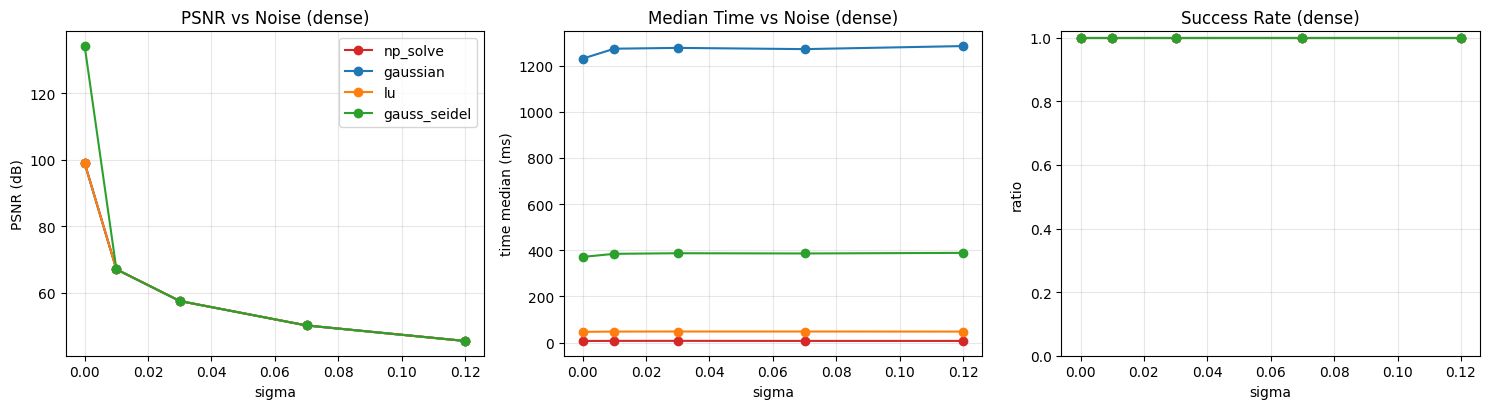

Saved: e:\Projects\Numerical-Analysis-Project\out\figures\metrics_dense.png


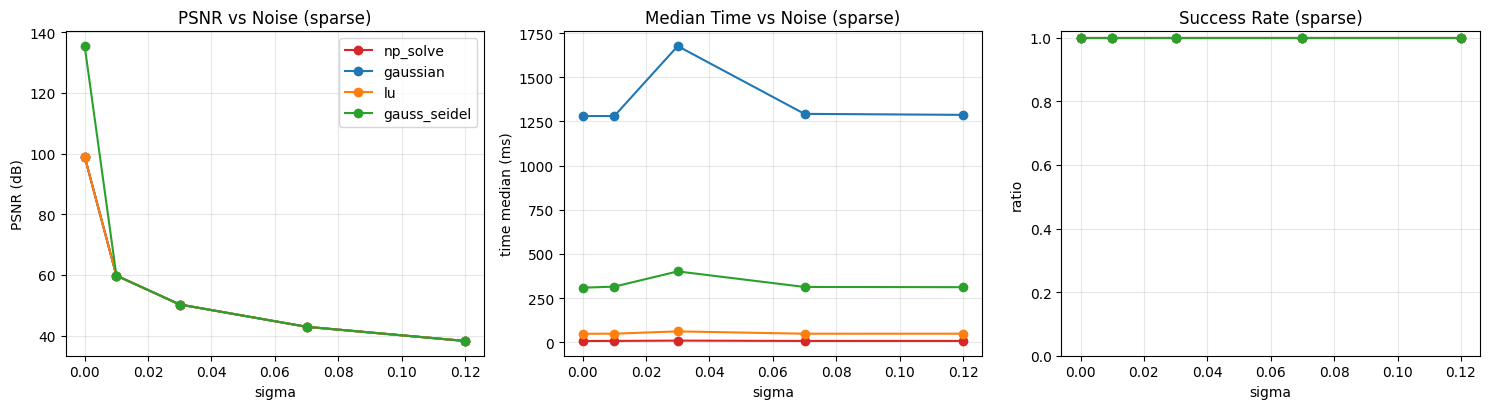

Saved: e:\Projects\Numerical-Analysis-Project\out\figures\metrics_sparse.png


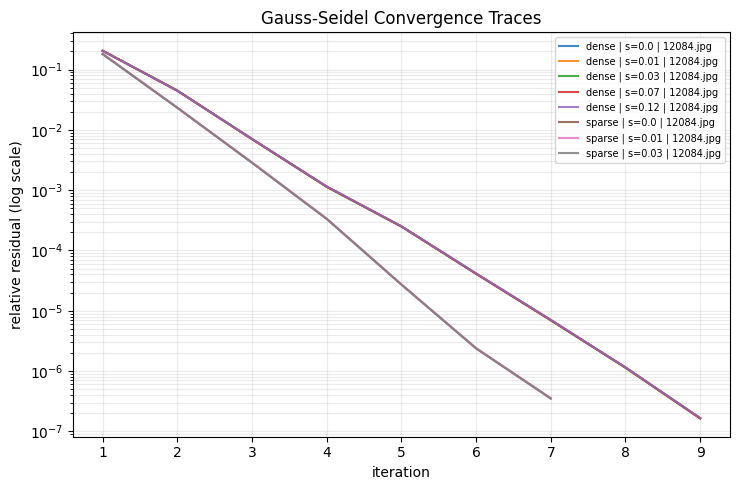

Saved: e:\Projects\Numerical-Analysis-Project\out\figures\gs_convergence_traces.png


In [ ]:
solver_order = ["np_solve", "gaussian", "lu", "gauss_seidel"]
color_map = {
    "np_solve": "tab:red",
    "gaussian": "tab:blue",
    "lu": "tab:orange",
    "gauss_seidel": "tab:green",
}

for matrix_type in ["dense", "sparse"]:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.2))

    for solver in solver_order:
        rows = [r for r in summary_rows if r["matrix_type"] == matrix_type and r["solver"] == solver]
        rows = sorted(rows, key=lambda x: x["sigma"])
        x = [r["sigma"] for r in rows]

        axes[0].plot(x, [r["psnr_mean"] for r in rows], marker="o", label=solver, color=color_map[solver])
        axes[1].plot(x, [r["time_ms_median"] for r in rows], marker="o", label=solver, color=color_map[solver])
        axes[2].plot(x, [r["success_rate"] for r in rows], marker="o", label=solver, color=color_map[solver])

    axes[0].set_title(f"PSNR vs Noise ({matrix_type})")
    axes[0].set_xlabel("sigma")
    axes[0].set_ylabel("PSNR (dB)")

    axes[1].set_title(f"Median Time vs Noise ({matrix_type})")
    axes[1].set_xlabel("sigma")
    axes[1].set_ylabel("time median (ms)")

    axes[2].set_title(f"Success Rate ({matrix_type})")
    axes[2].set_xlabel("sigma")
    axes[2].set_ylabel("ratio")
    axes[2].set_ylim(0.0, 1.02)

    for a in axes:
        a.grid(True, alpha=0.3)

    axes[0].legend()
    fig.tight_layout()
    path = FIG_DIR / f"metrics_{matrix_type}.png"
    fig.savefig(path, dpi=180)
    plt.show()
    print("Saved:", path)

# Plot Gauss-Seidel convergence traces for representative cases
if len(trace_rows) > 0:
    grouped = defaultdict(list)
    for tr in trace_rows:
        grouped[(tr["matrix_type"], tr["sigma"], tr["image_name"])].append(tr)

    # plot up to 8 curves to keep readable
    keys = sorted(grouped.keys())[:8]
    fig, ax = plt.subplots(figsize=(7.5, 5))
    for key in keys:
        rows = sorted(grouped[key], key=lambda x: x["iteration"])
        xs = [r["iteration"] for r in rows]
        ys = [r["relative_residual"] for r in rows]
        label = f"{key[0]} | s={key[1]} | {str(key[2])[:10]}"
        ax.plot(xs, ys, alpha=0.85, label=label)

    ax.set_yscale("log")
    ax.set_xlabel("iteration")
    ax.set_ylabel("relative residual (log scale)")
    ax.set_title("Gauss-Seidel Convergence Traces")
    ax.grid(True, which="both", alpha=0.25)
    ax.legend(fontsize=7)
    fig.tight_layout()
    path = FIG_DIR / "gs_convergence_traces.png"
    fig.savefig(path, dpi=180)
    plt.show()
    print("Saved:", path)


In [ ]:
# Wall figures: one panel per input image + explicit error-map panels

def make_wall(matrix_type, A, img, sigma, case_idx):
    blocks = split_blocks(img, CONFIG["block_size"])
    encrypted = blocks @ A.T
    noisy = encrypted + sigma * rng.standard_normal(encrypted.shape)

    def reconstruct_with(solver_name):
        out = decrypt_blocks(
            A,
            noisy,
            solver_name,
            gs_tol=CONFIG["gs_tol"],
            gs_max_iters=CONFIG["gs_max_iters"],
        )
        rec = merge_blocks(out["dec_blocks"], img.shape[0], img.shape[1], CONFIG["block_size"])
        return rec

    rec_np = reconstruct_with("np_solve")
    rec_g = reconstruct_with("gaussian")
    rec_lu = reconstruct_with("lu")
    rec_gs = reconstruct_with("gauss_seidel")

    fig, ax = plt.subplots(1, 5, figsize=(15, 3.5))
    fig.suptitle(f"{matrix_type} | case={case_idx + 1} | sigma={sigma}", fontsize=11)
    ax[0].imshow(img, cmap="gray", vmin=0, vmax=1)
    ax[0].set_title("Original")
    ax[1].imshow(rec_np, cmap="gray", vmin=0, vmax=1)
    ax[1].set_title("np.solve")
    ax[2].imshow(rec_g, cmap="gray", vmin=0, vmax=1)
    ax[2].set_title("Gaussian")
    ax[3].imshow(rec_lu, cmap="gray", vmin=0, vmax=1)
    ax[3].set_title("LU")
    ax[4].imshow(rec_gs, cmap="gray", vmin=0, vmax=1)
    ax[4].set_title("Gauss-Seidel")

    for a in ax:
        a.axis("off")

    fig.tight_layout(rect=[0, 0.03, 1, 0.92])
    out_path = FIG_DIR / f"wall_{case_idx + 1:02d}.png"
    fig.savefig(out_path, dpi=180)
    plt.close(fig)

    err_path = None
    if CONFIG.get("save_wall_error_maps", True):
        err_np = np.abs(rec_np - img)
        err_g = np.abs(rec_g - img)
        err_lu = np.abs(rec_lu - img)
        err_gs = np.abs(rec_gs - img)
        vmax = max(1e-8, float(np.max([err_np.max(), err_g.max(), err_lu.max(), err_gs.max()])))

        fig2, ax2 = plt.subplots(1, 4, figsize=(12, 3.1))
        fig2.suptitle(f"Error maps | case={case_idx + 1} | sigma={sigma}", fontsize=11)
        ims = [err_np, err_g, err_lu, err_gs]
        titles = ["|np - orig|", "|gauss - orig|", "|lu - orig|", "|gs - orig|"]
        for i in range(4):
            im = ax2[i].imshow(ims[i], cmap="inferno", vmin=0.0, vmax=vmax)
            ax2[i].set_title(titles[i])
            ax2[i].axis("off")
        cbar = fig2.colorbar(im, ax=ax2.ravel().tolist(), shrink=0.8)
        cbar.set_label("absolute error")
        fig2.tight_layout(rect=[0, 0.03, 1, 0.9])
        err_path = FIG_DIR / f"wall_err_{case_idx + 1:02d}.png"
        fig2.savefig(err_path, dpi=180)
        plt.close(fig2)

    print("Saved:", out_path)
    if err_path is not None:
        print("Saved:", err_path)
    return out_path, err_path


sigmas = sorted(CONFIG["noise_sigmas"])
if len(sigmas) == 0:
    raise RuntimeError("CONFIG['noise_sigmas'] must not be empty")

cases = []
for i, img in enumerate(images):
    matrix_type = "dense" if (i % 2 == 0) else "sparse"
    A = A_dense if matrix_type == "dense" else A_sparse
    sigma = sigmas[i % len(sigmas)]
    cases.append((matrix_type, A, img, sigma))

wall_outputs = []
wall_err_outputs = []
for case_idx, (matrix_type, A, img, sigma) in enumerate(cases):
    p1, p2 = make_wall(matrix_type, A, img, sigma, case_idx)
    wall_outputs.append(p1)
    if p2 is not None:
        wall_err_outputs.append(p2)

print("Generated", len(wall_outputs), "wall images")
if CONFIG.get("save_wall_error_maps", True):
    print("Generated", len(wall_err_outputs), "wall error-map images")

# Paper-ready combined figure: metric-selected best / median / worst (Gauss-Seidel)
if len(cases) > 0:
    case_scores = []
    for case_id, (matrix_type, _A, _img, sigma) in enumerate(cases):
        vals = [
            r["psnr_db"]
            for r in records
            if r["solver"] == "gauss_seidel"
            and r["matrix_type"] == matrix_type
            and r["image_idx"] == case_id
            and abs(float(r["sigma"]) - float(sigma)) < 1e-12
            and np.isfinite(float(r["psnr_db"]))
        ]
        score = float(np.median(vals)) if len(vals) > 0 else float("nan")
        case_scores.append((case_id, score))

    finite = [(cid, sc) for (cid, sc) in case_scores if np.isfinite(sc)]
    if len(finite) > 0:
        finite_sorted = sorted(finite, key=lambda x: x[1])
        pick_ids = [finite_sorted[-1][0], finite_sorted[len(finite_sorted) // 2][0], finite_sorted[0][0]]
        pick_labels = ["Best", "Median", "Worst"]
    else:
        pick_ids = sorted(set([0, len(cases) // 2, len(cases) - 1]))
        pick_labels = ["Case"] * len(pick_ids)

    fig, ax = plt.subplots(1, len(pick_ids), figsize=(4.8 * len(pick_ids), 4.2))
    if len(pick_ids) == 1:
        ax = [ax]

    for j, case_id in enumerate(pick_ids):
        matrix_type, A, img, sigma = cases[case_id]
        case_rng = np.random.default_rng(int(CONFIG["seed"]) + int(case_id) + 1000)
        blocks = split_blocks(img, CONFIG["block_size"])
        encrypted = blocks @ A.T
        noisy = encrypted + sigma * case_rng.standard_normal(encrypted.shape)

        out = decrypt_blocks(A, noisy, "gauss_seidel", CONFIG["gs_tol"], CONFIG["gs_max_iters"])
        rec = merge_blocks(out["dec_blocks"], img.shape[0], img.shape[1], CONFIG["block_size"])

        vals = [
            r["psnr_db"]
            for r in records
            if r["solver"] == "gauss_seidel"
            and r["matrix_type"] == matrix_type
            and r["image_idx"] == case_id
            and abs(float(r["sigma"]) - float(sigma)) < 1e-12
            and np.isfinite(float(r["psnr_db"]))
        ]
        psnr_med = float(np.median(vals)) if len(vals) > 0 else float("nan")

        ax[j].imshow(rec, cmap="gray", vmin=0, vmax=1)
        ax[j].set_title(f"{pick_labels[j]}\nCase {case_id+1} | {matrix_type}\nsigma={sigma}, medPSNR={psnr_med:.2f}")
        ax[j].axis("off")

    fig.suptitle("Paper Figure: Gauss-Seidel Best / Median / Worst by PSNR", fontsize=12)
    fig.tight_layout(rect=[0, 0.03, 1, 0.92])
    out_path = FIG_DIR / "paper_triptych.png"
    fig.savefig(out_path, dpi=200)
    plt.show()
    print("Saved:", out_path)


## Output Files

After running all cells:
- `out/config.json`
- `out/run_info.json`
- `out/results_detail.csv`
- `out/results_summary.csv`
- `out/results_solver_ranking.csv`
- `out/results_delta_vs_np_solve.csv`
- `out/traces/gs_convergence_traces.csv`
- `out/tables/table_dense_s*.tex` and `out/tables/table_sparse_s*.tex`
- `out/figures/metrics_dense.png`
- `out/figures/metrics_sparse.png`
- `out/figures/gs_convergence_traces.png`
- `out/figures/wall_*.png` (one per input image)
- `out/figures/wall_err_*.png` (error-map counterpart for each wall)
- `out/figures/paper_triptych.png`

To use your own images:
1. Put files in `data/custom_images`
2. Keep `CONFIG["data_source"] = "custom"`
3. Run all cells
